## LLM-as-a-Judge evaluation 

In this notebook, we test some approaches of evaluating responses Kai generates for different migration scenarios using an LLM as a judge.

The responses are generated by running Kai manually in vscode with different models. The diff files of the responses are stored as artifacts for simplicity.

#### Goal

Goal of this exercise is to:
- verify & finalize the evaluation metrics
- finalize the evaluation prompts

### Process

Run Tools  -->  Run Kai (manual, responses collected)  -->  Run Tools  -->  Evaluate

#### Running tools

In this notebook, we run following tools before and after applying fixes from Kai:
- `mvn compile`
- `mvn test` (only if tests are present for a given test case)
- `analyze` (kantra used for analysis)

#### Evaluate

For evaluating, three metrics are calculated:

1. Completeness (C): Measures whether the issue is completely resolved
2. Functional Parity (F): Measures whether existing functionality is maintained
3. Knock-on Effort (E): Measures how much effort is needed to address new issues caused by the fix

The total score is normalized for each metric and a final weighted score is produced between 0-10:

```
Final Score = 10 * (0.5 * C + 0.3 * F + 0.2 * E)
```

#### Pre-requisites

- Create a virtualenv using Jupyter for running cells in this notebook. Use [requirements.txt](../requirements.txt) to install dependencies needed. 
- Copy the .env.sample file to .env. Select the model you want to use for evaluation - Only Bedrock and ChatOpenAI are supported. Add your LLM key for the model you want to use. Once setup, run the following cell to load .env file.
- Make sure you have _java_ and _mvn_ installed.
- Download the latest _kantra_ binary.


In [21]:
%load_ext dotenv
%dotenv

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


Before we begin, we write some common code in the following cell which we will need later on. Run this cell before proceeding.

In [52]:
# some common functions we will need later on for the evaluation
import os
import sys
import yaml
import subprocess
import mplcursors
from git import Repo
from pathlib import Path
import matplotlib.pyplot as plt
from typing import Sequence, Optional
from dataclasses import dataclass, field

from langchain_openai import ChatOpenAI
from langchain_aws import ChatBedrockConverse

base_path_test_data = Path("test-data").absolute()
base_path_cloned_repos = (base_path_test_data / "apps")
base_path_test_artifacts = (base_path_test_data / "artifacts")
base_path_cloned_repos.mkdir(parents=True, exist_ok=True)
base_path_test_artifacts.mkdir(parents=True, exist_ok=True)
## NOTE: make sure this is correct for your system
kantra_path = Path.home() / ".kantra" / "kantra"
## NOTE: set these values
JAVA_HOME = Path("/usr/lib/jvm/java-21-openjdk/")
JAVA_BIN = JAVA_HOME / "bin"

def parse_yaml(path: Path): 
    with open(path, "r") as f: return yaml.safe_load(f)

def parse_yaml_key(tc_path: str, key: str):
    parsed = parse_yaml(tc_path)
    return parsed.get(key)

@dataclass
class TestAppCoords:
    path: Path
    
    name: str = "__unpopulated__"
    repo_path: Path = Path("__unpopulated__")
    url: str = "__unpopulated__"
    branch: str = "__unpopulated__"

    def __post_init__(self):
        parsed = parse_yaml(self.path)
        self.name = parsed.get("name")
        self.url = parsed.get("source_code").get("git").get("url")
        self.branch = parsed.get("source_code").get("git").get("branch")
        self.repo_path = base_path_cloned_repos / self.name

@dataclass
class TestCaseCoords:
    path: Path
    variant: str
    diff_path: Path
    app_coords: TestAppCoords

    name: str = "__unpopulated__"
    description: str = "__unpopulated__"
    targets: list[str] = field(default_factory=list)
    test_selectors: list[str] = field(default_factory=list)
    base_path_before_artifacts: Path = Path("__unpopulated__")
    base_path_after_artifacts: Path = Path("__unpopulated__")
    
    def __post_init__(self):
        parsed = parse_yaml(self.path)
        self.name = parsed.get("name")
        self.description = parsed.get("description")
        self.targets = parse_yaml_key(self.app_coords.path, "targets")
        self.test_selectors = parse_yaml_key(self.path, "testSelectors")
        self.base_path_before_artifacts = base_path_test_artifacts / self.app_coords.name / self.name /self.variant / "before"
        self.base_path_after_artifacts = base_path_test_artifacts / self.app_coords.name / self.name / self.variant / "after"
        self.base_path_before_artifacts.mkdir(parents=True, exist_ok=True)
        self.base_path_after_artifacts.mkdir(parents=True, exist_ok=True)

def clone_repo(url: str, branch: str, path: Path):
    try:
        Repo.clone_from(url, depth=1, single_branch=True, branch=branch, to_path=path)
    except Exception as e:
        if "already exists" not in str(e):
            print("fatal error cloning repo")
            sys.exit(1)

def get_model():
    provider = os.getenv("model_provider")
    model_id = os.getenv("model_id")
    if not model_id or not provider:
        raise ValueError("model_id and/or model_provider are not set")
    match provider:
        case "chatbedrock":
            key_id = os.getenv("aws_access_key_id")
            access_key = os.getenv("aws_secret_access_key")
            region = os.getenv("region")
            if not region or not access_key or not key_id:
                raise ValueError("aws_region and/or aws_secret_access_key and/or aws_access_key_id is not set")
            return ChatBedrockConverse(
                model_id=model_id,
                aws_access_key_id=key_id,
                aws_secret_access_key=access_key,
                region_name=region,
                temperature=0.0,
            )
        case "chatopenai":
            api_key = os.getenv("OPEANAI_API_KEY") or os.getenv("api_key")
            if not api_key:
                raise ValueError("OPEANAI_API_KEY or api_key is not set")
            return ChatOpenAI(model=model_id, api_key=api_key, temperature=0.0)
        case _:
            raise ValueError(f"Invalid model provider: {provider}")

def run_command(cmd: list[str], stdout_path: Path, stderr_path: Path, cwd: Path, env_vars: dict[str, str] = {}):
    pwd = os.getcwd()
    os.chdir(cwd)
    result = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True, env=env_vars)
    with open(stdout_path, "w") as f:
        f.write(result.stdout)
    with open(stderr_path, "w") as f:
        f.write(result.stderr)
    os.chdir(pwd)

def git_apply_diff(tc: TestCaseCoords):
    repo = Repo(tc.app_coords.repo_path)
    repo.git.apply(tc.diff_path)

def git_reset(tc: TestCaseCoords):
    repo = Repo(tc.app_coords.repo_path)
    repo.git.reset("--hard")

def run_mvn(tc: TestCaseCoords, after: bool = False, env_vars: dict[str, str] = {}):
    base_path = (tc.base_path_after_artifacts if after else tc.base_path_before_artifacts) / "mvn"
    base_path.mkdir(parents=True, exist_ok=True)
    run_command(
        cmd=["mvn", "compile"], 
        stdout_path=base_path / "mvn_compile.log",
        stderr_path=base_path / "mvn_compile.err", 
        cwd=tc.app_coords.repo_path,
        env_vars=env_vars,
    )

def run_mvn_test(tc: TestCaseCoords, after: bool = False, env_vars: dict[str, str] = {}):
    base_path = (tc.base_path_after_artifacts if after else tc.base_path_before_artifacts) / "mvn"
    base_path.mkdir(parents=True, exist_ok=True)
    run_command(
        cmd=["mvn", "test", f"-Dtest={','.join(tc.test_selectors)}"], 
        stdout_path=base_path / "mvn_test.log",
        stderr_path=base_path / "mvn_test.err", 
        cwd=tc.app_coords.repo_path,
        env_vars=env_vars,
    )

def run_kantra(tc: TestCaseCoords, after: bool = False, env_vars: dict[str, str] = {}):
    base_path = (tc.base_path_after_artifacts if after else tc.base_path_before_artifacts) / "kantra"
    base_path.mkdir(parents=True, exist_ok=True)
    kantra_cmd = [
        kantra_path, "analyze", "--overwrite", 
        "--input", tc.app_coords.repo_path, 
        "--output", base_path
    ]
    for target in tc.targets:
        kantra_cmd.append("--target")
        kantra_cmd.append(target.strip('"'))
    env_vars = os.environ.copy()
    env_vars["JAVA_HOME"] = JAVA_HOME
    env_vars["PATH"] = os.environ["PATH"] + ":" + str(JAVA_BIN)
    run_command(
        cmd=kantra_cmd, 
        stdout_path=base_path / "kantra.log", 
        stderr_path=base_path / "kantra.err", 
        cwd=tc.app_coords.repo_path,
        env_vars=env_vars,
    )


@dataclass(frozen=True)
class ExperimentResults:
    title: str
    completeness: float 
    functional_parity: float
    residual_effort: float

def plot_scores_grouped(
    experiments: Sequence[Sequence[ExperimentResults]],
    experiment_titles: Sequence[str],
    weights: tuple[float, float, float] = (0.5, 0.3, 0.2),
    scale: float = 10.0,
    colors: Optional[tuple[str, str, str]] = None,
    figsize: tuple[float, float] = (9, 0.9),
):
    assert len(experiments) == len(experiment_titles), "titles must match experiments"
    if colors is None:
        colors = ("deepskyblue", "mediumaquamarine", "sandybrown")
    comp_names = ("C (50%)", "FP (30%)", "R (20%)")
    wC, wFP, wR = weights
    y_positions, y_labels = [], []
    y = 0.0
    intra_step = 1.0
    inter_gap_extra = 0.6  # extra space after each experiment
    bars = []  # keep handles for optional tooltips
    fig, ax = plt.subplots(figsize=(figsize[0], max(figsize[1], 0.6 + 0.45 * sum(len(vs) for vs in experiments))))
    for exp_idx, (title, variants) in enumerate(zip(experiment_titles, experiments)):
        for var in variants:
            cC = scale * wC * var.completeness
            cFP = scale * wFP * var.functional_parity
            cR = scale * wR * var.residual_effort
            contribs = (cC, cFP, cR)
            total = sum(contribs)
            left = 0.0
            for contrib, cname, color in zip(contribs, comp_names, colors):
                h = ax.barh(y, contrib, left=left, label=cname, color=color)
                # stash metadata for tooltips
                bars.append((h[0], {
                    "experiment": title,
                    "variant": var.title,
                    "component": cname,
                    "value": contrib,
                    "total": total
                }))
                left += contrib
            y_positions.append(y)
            label = f"{title}: {var.title}" if len(variants) > 1 else title
            y_labels.append(label)
            y += intra_step

        y += inter_gap_extra

    # Axes cosmetics
    ax.set_xlim(0, scale)
    ax.set_yticks(y_positions)
    ax.set_yticklabels(y_labels)
    ax.set_xlabel(f"Weighted Score (0–{int(scale)})")
    ax.set_title("Experiment Scores")
    ax.grid(axis="x", linestyle=":", alpha=0.35)
    # Remove legend per requirement
    leg = ax.get_legend()
    if leg:
        leg.remove()

    cursor = mplcursors.cursor([b for b, _ in bars], hover=True)
    @cursor.connect("add")
    def _on_add(sel):
        artist = sel.artist
        meta = next((m for b, m in bars if b is artist), None)
        if meta:
            sel.annotation.set_text(
                f"{meta['experiment']}\n{meta['variant']}\n"
                f"{meta['component']}: {meta['value']:.2f}\n"
                f"Total: {meta['total']:.2f}"
            )
        sel.annotation.get_bbox_patch().set_alpha(0.9)

    plt.tight_layout()
    plt.show()

In the following cell, we have our LLM-as-a-Judge code. Run this cell before proceeding.

In [23]:
import re
from git import Repo, Head
from pathlib import Path
from typing import Annotated
from dataclasses import dataclass, field
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent

@dataclass
class EvaluationTools:
    tc: TestCaseCoords

    changed_filepaths: list[str] = field(default_factory=list)
    changed_filelist: list[str] = field(default_factory=list)
    changed_files: list[str] = field(default_factory=dict)
    architecture_md: str = "Not available"

    def init(self):
        self.architecture_md = (self.tc.app_coords.path.parent / "architecture.md").read_text()
        self.repo = Repo(self.tc.app_coords.repo_path)
        self.repo.git.reset("--hard")
        self.repo.git.apply(self.tc.diff_path)
        self.changed_filepaths = self.repo.git.diff("--name-only").split()
        self.changed_filelist = [
            str(p.relative_to(self.tc.app_coords.repo_path))
            for p in Path(self.tc.app_coords.repo_path).rglob("*")
            if p.is_file() and not any(part.startswith(".") or part.startswith("target") for part in p.relative_to(self.tc.app_coords.repo_path).parts)
        ]
        for path in self.changed_filepaths:
            self.changed_files[path] = (self.tc.app_coords.repo_path / Path(path)).read_text()
        self.repo.git.reset("--hard")

    def get_architecture_tool(self):
        architecture_md = self.architecture_md
        @tool
        def get_architecture():
            """Returns the architecture of the application in markdown format"""
            return architecture_md
        return get_architecture
    
    def get_changed_files_tool(self):
        changed_filepaths = self.changed_filepaths
        @tool
        def get_changed_files():
            """Returns the list of files that have been changed after applying the fixes"""
            return "\n".join(changed_filepaths)
        return get_changed_files
    
    def get_file_content_tool(self):
        changed_files = self.changed_files
        repo_path = self.tc.app_coords.repo_path
        @tool
        def get_file_content(
            file_path: Annotated[str, "Relative path to the file"],
            pre_migration: Annotated[bool, "Return a pre-migration version, defaults to False"] = False):
            """Returns the current content of a file, if pre_migration is set, returns its old content"""
            if pre_migration or file_path not in self.changed_files:
                return (repo_path / file_path).read_text()
            return changed_files[file_path]
        return get_file_content

    def get_list_files_tool(self):
        changed_filelist = self.changed_filelist
        repo_path = self.tc.app_coords.repo_path
        @tool
        def list_files(
            pattern: Annotated[str, "Python regex pattern to match files against"],
            pre_migration: Annotated[bool, "Set to True to return pre-migration list of files, defaults to False"] = False):
            """Returns a list of files in the source code matching given pattern"""
            all_files = changed_filelist
            if pre_migration:
                all_files = [str(p.relative_to(repo_path)) 
                    for p in Path(repo_path).rglob("*")
                    if p.is_file() and not any(part.startswith(".") or part.startswith("target") for part in p.relative_to(self.repo_path).parts)]
            return "\n".join([f for f in all_files.split("\n") if re.match(pattern, f)])
        return list_files
    
    def get_test_output_tool(self):
        before_tests: Path = self.tc.base_path_before_artifacts / "mvn" / "mvn_test.log"
        after_tests: Path = self.tc.base_path_after_artifacts / "mvn" / "mvn_test.log"
        @tool
        def get_test_output(
            pre_migration: Annotated[bool, "Set to True to return pre-migration test output, defaults to False"] = False,
        ):
            """Returns results of the applicable behavioral tests"""
            if pre_migration and before_tests.exists():
                return before_tests.read_text()
            elif not pre_migration and after_tests.exists():
                return after_tests.read_text()
            return "Tests not available"
        return get_test_output
    
    def get_kantra_output_diff_tool(self):
        before_kantra: Path = self.tc.base_path_before_artifacts / "kantra" / "output" / "output.yaml"
        after_kantra: Path = self.tc.base_path_after_artifacts / "kantra" / "output" / "output.yaml"
        @tool
        def get_static_analysis_issues_post_migration():
            """Returns new migration issues introduced after the migration fix"""
            return after_kantra.read_text() - before_kantra.read_text()
        return get_static_analysis_issues_post_migration
    
    def get_compilation_issues_post_migration_tool(self):
        after_compilation: Path = self.tc.base_path_after_artifacts / "mvn" / "mvn_compile.log"
        @tool
        def get_compilation_issues_post_migration():
            """Returns new compilation issues introduced after the migration fix"""
            return after_compilation.read_text()
        return get_compilation_issues_post_migration

@dataclass
class EvaluationInput:
    source_tech: str
    target_tech: str
    issue: str
    issue_notes: str
    tc_path: Path
    tools: EvaluationTools

@dataclass
class EvaluationResults:
    score: float = 0.0
    responses: list[any] = field(default_factory=list)


In [24]:
def run_completeness_agent(
    inp: EvaluationInput
) -> EvaluationResults:
    COMPLETENESS_PROMPTS = {
    "system": """You are a senior software engineer expert in migrating applications from one technology to another.""",
    "user_summarize": """You are reviewing a code change made to fix a migration issue identified by a static analysis tool.
The application is being migrated from {source_tech} to {target_tech}.
You are provided with:
- The original issue description
- Developer notes describing the intended fix (consider these the only source of truth)
- Access to a set of tools that can inspect the codebase

## Your task

Determine how completely the code changes implement the fix as described in the developer notes—no more, no less.
Your job is to compare implementation (actual code) against intent (developer notes).

## Evaluation Rules

- Stick strictly to the notes when comparing. They are the authoritative reference.
- Do not assume additional requirements, behaviors, or conventions.
- Use tools thoughtfully. Only gather information necessary to confirm alignment between the notes and the actual code changes.
- Be specific. When identifying missing or incomplete work, clearly describe what evidence led you to that conclusion.
- Be concise but thorough. Focus on correctness and completeness.
- Refer explicitly to evidence from the codebase when making your assessment.
- Avoid subjective language like "it seems" or "probably".

There are three possible outcomes for your evaluation:

1. COMPLETELY_FIXED:
   - All changes described in the notes are present and correctly implemented.
   - No missing, incorrect, or contradictory work remains.
2. PARTIALLY_FIXED:
   - Some changes described in the notes are implemented, but at least one required modification is missing, incorrect, or incomplete.
3. UNFIXED:
   - *None* of the changes described in the notes are addressed.
   - OR, the changes leave the code in a broken state.

## Output Format

If the issue is completely fixed, respond in the following format:

```
COMPLETELY_FIXED

<Brief summary explaining how the implemented changes align exactly with the notes and fully resolve the issue.>
```

If the issue is partially fixed, identify outstanding changes. Try to group them logically together to keep the changes distinct.
Respond in the following format:

```
PARTIALLY_FIXED

<Brief summary explaining why the fix is incomplete or incorrect, and what parts are missing or deviate from the notes.>

## Outstanding issues

1. <First issue summary>
2. <Second issue summary>
...
```

If the issue is not fixed at all, respond in the following format:

```
UNFIXED

<Brief summary explaining why you think the issue is completely unfixed.>
```


Here are your inputs:
## The issue identified was:
{issue}

## Here are the notes about the issue:
{issue_notes}
""",
    "user_rate": """We used a static analysis tool to identify a migration issue in the application which needs to be migrated from {source_tech} to {target_tech}.
We fixed the issue and asked a senior software engineer to review the changes. The engineer reviewed the changes and provided a summary of the changes made.

## Your task

Your goal is to:

- Analyze each *distinct unresolved issue* described in the summary.
- Assess the complexity of fixing each issue for given application.
- Finally, provide a rating for every issue based on the following scale:
    - TRIVIAL_CHANGES_NEEDED: Requires only a few small, localized modifications to files in the codebase (e.g., renaming, updating a parameter, minor logic tweak, or adding a missing import).
    - COMPLEX_CHANGES_NEEDED: Requires multiple related changes across files, complex logic changes, or coordination between components or services.
    - REDESIGN_NEEDED: Indicates a fundamental design or architectural flaw requiring a significant refactor or reimplementation of core logic.

## Guidelines
- Focus only on issues explicitly described in the summary.
- Do not invent or infer new issues beyond what is stated.
- Use architectural reasoning (e.g., cross-file dependencies, data flow, API contracts) to decide the appropriate rating.
- Each issue should have a short justification describing why it falls into that category.
- Maintain objectivity — avoid vague or subjective language like “probably complex” or “seems fine.”
- If there are no issues identified in the summary, rate the migration as COMPLETE.
- Look at architecture of the application to help you make the decision.

Produce your response in following format:

```
---
<Issue title>
<Brief reasoning (2~3 lines) behind the rating.>
Rating: <TRIVIAL_CHANGES_NEEDED | COMPLEX_CHANGES_NEEDED | REDESIGN_NEEDED>
---
<Issue 2 title>
<Brief reasoning (2~3 lines) behind the rating.>
Rating: <TRIVIAL_CHANGES_NEEDED | COMPLEX_CHANGES_NEEDED | REDESIGN_NEEDED>
...
```

Here are your inputs:

## Issue we fixed
{issue}

## Summary
{summary}
""",
}
    responses = []
    agent = create_react_agent(
        model=get_model(),
        tools=[
            inp.tools.get_architecture_tool(),
            inp.tools.get_changed_files_tool(),
            inp.tools.get_file_content_tool(),
        ],
        prompt=COMPLETENESS_PROMPTS["system"],
    )
    response = agent.invoke(
        {
            "messages": [
                {
                    "role": "user",
                    "content": COMPLETENESS_PROMPTS["user_summarize"].format(
                        source_tech=inp.source_tech,
                        target_tech=inp.target_tech,
                        issue=inp.issue,
                        issue_notes=inp.issue_notes,
                    )
                },
            ]
        },
        { "recursion_limit": 50 }
    )
    responses.append(response)
    summarized_content: str = response["messages"][-1].content
    
    # return binary answers first
    if "UNFIXED" in summarized_content:
        return 0
    elif "COMPLETELY_FIXED" in summarized_content:
        return 1
    
    # for partial fixes, a base score of 0.2 will be added
    rate_agent = create_react_agent(
        model=get_model(),
        tools=[inp.tools.get_architecture_tool()],
        prompt=COMPLETENESS_PROMPTS["system"],
    )
    response = rate_agent.invoke(
        {
            "messages": [
                {
                    "role": "user",
                    "content": COMPLETENESS_PROMPTS["user_rate"].format(
                        source_tech=inp.source_tech,
                        target_tech=inp.target_tech,
                        issue=inp.issue,
                        summary=response["messages"][-1].content,
                    )
                },
            ]
        },
        { "recursion_limit": 50 }
    )
    rating_content: str = response["messages"][-1].content
    score = 0.8
    METRICS = {
        "TRIVIAL_CHANGES_NEEDED": 0.05,
        "COMPLEX_CHANGES_NEEDED": 0.2,
        "REDESIGN_NEEDED": 0.7,
    }
    for line in rating_content.split("\n"):
        match = re.search(r"Rating:\s*([^\n\r]+)", line)
        if match:
            val = float(METRICS.get(match.group(1).strip()))
            score -= val
    responses.append(response)
    return EvaluationResults(
        score=round(max(score + 0.2, 0), 2),
        responses=responses,
    )


In [25]:
def run_functional_correctness_agent(
    inp: EvaluationInput
):
    FUNCTIONAL_CORRECTNESS_PROMPTS = {
        "system": "You are a senior engineering expert in migrating source code as well as reviewing source code that is migrated from {source_tech} to {target_tech}.",
        "user_summarize": """You are overseeing migration of a codebase from {source_tech} to {target_tech}.
You are evaluating whether the migrated code preserves the functional behavior of its pre-migration version.

You are given:
- The original migration issue being fixed.
- Various tools to access post migration artifacts such as changed files, contents of pre and post migration files, results of behavioral tests (if present) and more.

## Your task

Determine if the post-migration code behaves functionally equivalent to the pre-migration code.
Focus strictly on runtime behavior, input/output consistency, and side effects.
Ignore stylistic, architectural, or performance differences unless they alter functional outcomes.

* Evidence-driven only.
- Base all reasoning on observable evidence from code or test results.
- Never assume developer intent beyond provided inputs.

* Understand the baseline.
- Examine the pre-migration code for:
  - Control flow and data flow
  - API contracts and return values
  - Input constraints and edge-case handling
  - External side effects (I/O, state changes, dependencies)

* Compare precisely.
- For each changed function or module, verify:
  - Input/Output equivalence
  - Algorithmic logic and branching consistency
  - Data transformations and validation rules
  - Exception and error handling behavior
  - API interface and dependency interactions
- Anchor every claim to evidence (specific functions, variables, or test traces).
- Differentiate functional logic vs configuration/environment clearly.
- Avoid judgmental or speculative phrasing — report observations only.
- Use deterministic comparisons: “X no longer calls Y,” “Return type changed from boolean to ResponseEntity,” etc.

* Handle tests carefully.
- Ignore failures caused purely by environment/config differences (e.g., path changes, dependency injection mismatches).
- Treat failures that reflect logic or data regressions as evidence of non-equivalence.
- Even if the tests fail, carefully analyze the test code itself to see if the functionality its testing is preserved.

* Do not overreach.
- Do not infer new requirements, “intended” fixes, or performance expectations.
- This is not a code-quality or completeness evaluation — only functional equivalence.

## Output requirements

- Summarize concrete evidence for any differences affecting functionality.
- Group related findings into distinct, logically separate issues.
- Provide a rating for the functional parity based on the scale below:
  - EQUIVALENT
    - Full behavioral parity. All functional logic and data flow preserved.
    - All tests pass or only harness/config mismatches.
    - Identical algorithms, APIs, and side effects.
  - CLOSELY_EQUIVALENT
    - Parity in business logic; minor config or integration adjustments needed.
    - Failing tests traceable solely to environment or dependency setup.
    - Code identical except for platform-specific or annotation-level differences.
  - SOMEWHAT_EQUIVALENT
    - Core logic intact but minor deviations exist (e.g., missing validation, altered edge case).
    - Some functional tests fail; failures fixable via small code edits.
    - Small discrepancies in conditions, defaults, or error handling.
  - NOT_EQUIVALENT
    - Major behavioral divergence — functionality changed, omitted, or broken.
    - Tests fail due to true logic or data-flow regressions.
    - Missing branches, incorrect return paths, lost side effects, or altered API behavior.

Produce your output in format below:

```
<Brief, objective reasoning for every distinct issue you found — reference specific files, functions, or behaviors as evidence.>

Rating: <EQUIVALENT | CLOSELY_EQUIVALENT | SOMEWHAT_EQUIVALENT | NOT_EQUIVALENT>

```

Here are your inputs:

## Original issue

{issue}

## Applicable behvioral tests
{test_selectors}
""",
    }
    responses = []
    summarize_agent = create_react_agent(
        model=get_model(),
        tools=[
            inp.tools.get_architecture_tool(),
            inp.tools.get_changed_files_tool(),
            inp.tools.get_file_content_tool(),
            inp.tools.get_list_files_tool(),
            inp.tools.get_test_output_tool(),
        ],
        prompt=FUNCTIONAL_CORRECTNESS_PROMPTS["system"].format(
            source_tech=inp.source_tech,
            target_tech=inp.target_tech,
        ),
    )
    test_selectors=parse_yaml_key(inp.tc_path, "testSelectors")
    resopnse = summarize_agent.invoke(
      {
        "messages": [
          {
              "role": "user",
              "content": FUNCTIONAL_CORRECTNESS_PROMPTS["user_summarize"].format(
                  source_tech=inp.source_tech,
                  target_tech=inp.target_tech,
                  issue=inp.issue,
                  test_selectors="\n- ".join(test_selectors) if test_selectors != "__unknown__" else "Not available",
              )
          },
        ],
      },
      { "recursion_limit": 50 }
    )
    responses.append(resopnse)
    for line in resopnse["messages"][-1].content.split("\n"):
        match = re.search(r"Rating:\s*([^\n\r]+)", line)
        if match:
            val = float({
              "EQUIVALENT": 1,
              "CLOSELY_EQUIVALENT": 0.75,
              "SOMEWHAT_EQUIVALENT": 0.5,
              "NOT_EQUIVALENT": 0,
            }.get(match.group(1).strip()))
            return EvaluationResults(
                score=val,
                responses=responses,
            )
    raise Exception("No rating found")

In [26]:
def run_residual_effort_agent(
    inp: EvaluationInput
):
    RESIDUAL_EFFORT_PROMPTS = {
        "system": "You are a senior engineering expert in migrating source code as well as reviewing source code that is migrated from {source_tech} to {target_tech}.",
        "user_summarize": """You are overseeing migration of a codebase from {source_tech} to {target_tech}.
You are evaluating the impact of changes made to the codebase to fix a migration issue.
After fixing a specific migration issue, the compilation/build and static analysis tools were re-run.
These tools have reported new issues — some may be compilation or build errors, while others may be new migration issues identified by the migration analyzer.
Your task is to determine what new issues were introduced, how severe they are, and how complex it would be to fix them.

You are given:
- The original migration issue being fixed.
- Various tools to access post migration artifacts such as compilation / build and static analysis tooling post migration, changed files, contents of pre and post migration files, among others.

## Your task

Evaluate the *impact* and *complexity* of newly introduced issues after applying the migration fix.

Follow a deterministic, evidence-based process as described below:

* Understand the new issues
- Collect all new issues reported after the fix — both from build/compilation logs and static analysis tools.
- Distinguish between:
  - Compilation / Build issues (syntax, missing symbols, type mismatches, dependency errors, etc.)
  - Migration issues (detected by static analysis tooling that verifies framework-specific rules or patterns).
- Group the new issues into distinct, logically separate issues. For instance, multiple issues may be fixed by a single fix. Or, more than one issues may be closely related to each other requiring interdependent fixes.
  - Multiple tool reports that stem from one root cause → treat as one issue.
  - Separate unrelated failures → treat as different issues.

* Evidence-driven only.
- For each distinct issue:
  - Inspect pre- and post-migration code to determine what caused it.
  - Identify:
    - Impacted functions, modules, or APIs
    - Root cause (e.g., missing import, incompatible API call, incorrect type adaptation)
    - Possible scope of fix (localized vs. cross-component)

* Compare precisely.
- Anchor every claim to evidence (specific functions, variables, or test traces).
- Avoid judgmental or speculative phrasing — report observations only.

* Do not overreach.
- Do not infer new requirements, “intended” fixes, or performance expectations.
- This is not a code-quality or completeness evaluation — only functional equivalence.

## Output requirements

- For each *logically distinct* issue, provide a work estimate for fixing the issue on a scale given below:
    - TRIVIAL_CHANGES_NEEDED: Requires only a few small, localized modifications to files in the codebase (e.g., renaming, updating a parameter, minor logic tweak, or adding a missing import).
    - COMPLEX_CHANGES_NEEDED: Requires multiple related changes across files, complex logic changes, or coordination between components or services.
    - REDESIGN_NEEDED: Indicates a fundamental design or architectural flaw requiring a significant refactor or reimplementation of core logic.

Produce your output in format below:

```
---
<Issue title>

<Brief, objective reasoning for every distinct issue you found — reference specific files, functions, or behaviors as evidence.>

Rating: <TRIVIAL_CHANGES_NEEDED | COMPLEX_CHANGES_NEEDED | REDESIGN_NEEDED>
---
<Issue 2 title>

<Brief, objective reasoning for every distinct issue you found — reference specific files, functions, or behaviors as evidence.>

Rating: <TRIVIAL_CHANGES_NEEDED | COMPLEX_CHANGES_NEEDED | REDESIGN_NEEDED>
---
...and so on.
```

If no new issues are introduced, respond with:

```
NO_ISSUES_INTRODUCED
```

Here are your inputs:

## Original migration issue

{issue}
""",
    }
    responses = []
    summarize_agent = create_react_agent(
        model=get_model(),
        tools=[
            inp.tools.get_architecture_tool(),
            inp.tools.get_changed_files_tool(),
            inp.tools.get_file_content_tool(),
            inp.tools.get_list_files_tool(),
            inp.tools.get_test_output_tool(),
            inp.tools.get_compilation_issues_post_migration_tool(),
        ],
        prompt=RESIDUAL_EFFORT_PROMPTS["system"].format(
            source_tech=inp.source_tech,
            target_tech=inp.target_tech,
        ),
    )
    test_selectors=parse_yaml_key(inp.tc_path, "testSelectors")
    response = summarize_agent.invoke(
      {
        "messages": [
          {
              "role": "user",
              "content": RESIDUAL_EFFORT_PROMPTS["user_summarize"].format(
                  source_tech=inp.source_tech,
                  target_tech=inp.target_tech,
                  issue=inp.issue,
                  test_selectors="\n- ".join(test_selectors) if test_selectors != "__unknown__" else "Not available",
              )
          },
        ],
      },
      { "recursion_limit": 50 }
    )
    responses.append(response)
    score = 1
    for line in response["messages"][-1].content.split("\n"):
        if "NO_ISSUES_INTRODUCED" in line:
          return 1
        match = re.search(r"Rating:\s*([^\n\r]+)", line)
        if match:
            val = float({
              "TRIVIAL_CHANGES_NEEDED": 0.05,
              "COMPLEX_CHANGES_NEEDED": 0.2,
              "REDESIGN_NEEDED": 0.7,
            }.get(match.group(1).strip()))
            score -= val
    return EvaluationResults(
        score=round(max(score, 0), 2),
        responses=responses,
    )

In [7]:
from concurrent.futures import ThreadPoolExecutor

def run_evaluation(input: EvaluationInput):
    with ThreadPoolExecutor(max_workers=3) as executor:
        futures = {
            "completeness": executor.submit(run_completeness_agent, input),
            "function_parity": executor.submit(run_functional_correctness_agent, input),
            "residual_effort": executor.submit(run_residual_effort_agent, input),
        }
        vals = {}
        for k, fut in futures.items():
            vals[k] = fut.result(timeout=180)  # raises on error/timeout
    return vals

## Scanario 1:  Ehcache 2 to 3 upgrade

| App         | Complexity |
|-------------|------------|
| Petclinic   |    High    |

See description of the issue found [here](../apps/petclinic/test_cases/ehcache-2-to-3/tc.yaml).

See notes on expected fix [here](../apps/petclinic/test_cases/ehcache-2-to-3/notes.md).


In [11]:
# run tools -> apply diff -> run tools
# with agent and non-agent mode

petclinic_app = TestAppCoords(
    path=Path("../apps/petclinic/app.yaml").absolute(),
)

tc_1_agent_mode: TestCaseCoords = TestCaseCoords(
    path=Path("../apps/petclinic/test_cases/ehcache-2-to-3/tc.yaml").absolute(),
    variant="agent",
    diff_path=Path("test-data/diffs/ehcache-2-to-3/gpt_4o_agent.diff").absolute(),
    app_coords=petclinic_app,
)

tc_1_non_agent_mode: TestCaseCoords = TestCaseCoords(
    path=Path("../apps/petclinic/test_cases/ehcache-2-to-3/tc.yaml").absolute(),
    variant="non-agent",
    diff_path=Path("test-data/diffs/ehcache-2-to-3/gpt_4o.diff").absolute(),
    app_coords=petclinic_app,
)

clone_repo(petclinic_app.url, petclinic_app.branch, petclinic_app.repo_path)
## Agent mode
# run tools
run_mvn(tc=tc_1_agent_mode)
run_mvn_test(tc=tc_1_agent_mode)
run_kantra(tc=tc_1_agent_mode)
# apply diff
git_apply_diff(tc=tc_1_agent_mode)
# run tools again
run_mvn(tc=tc_1_agent_mode, after=True)
run_mvn_test(tc=tc_1_agent_mode, after=True)
run_kantra(tc=tc_1_agent_mode, after=True)
# reset
git_reset(tc=tc_1_agent_mode)
## Non-agent mode
# run tools
run_mvn(tc=tc_1_non_agent_mode)
run_mvn_test(tc=tc_1_non_agent_mode)
run_kantra(tc=tc_1_non_agent_mode)
# apply diff
git_apply_diff(tc=tc_1_non_agent_mode)
# run tools again
run_mvn(tc=tc_1_non_agent_mode, after=True)
run_mvn_test(tc=tc_1_non_agent_mode, after=True)
run_kantra(tc=tc_1_non_agent_mode, after=True)
# reset
git_reset(tc=tc_1_non_agent_mode)
# Initialize tools
tc1_agent_tools = EvaluationTools(tc=tc_1_agent_mode)
tc1_agent_tools.init()
tc1_non_agent_tools = EvaluationTools(tc=tc_1_non_agent_mode)
tc1_non_agent_tools.init()

Now we have all the data we need for pre and post fix. We will use an LLM to evaluate the responses.

In [42]:

tc1_agent_results = run_evaluation(
    EvaluationInput(
        source_tech="Spring Framework 5",
        target_tech="Spring Framework 6",
        issue=tc_1_agent_mode.description,
        issue_notes=(tc_1_agent_mode.path.parent / "notes.md").read_text(),
        tc_path=tc_1_agent_mode.path,
        tools=tc1_agent_tools,
    ))

print("--- Results for agent mode ---")
print("Completeness score: ", tc1_agent_results["completeness"].score)
print("Functional parity score: ", tc1_agent_results["function_parity"].score)
print("Residual effort score: ", tc1_agent_results["residual_effort"].score)

--- Results for agent mode ---
Completeness score:  0.8
Functional parity score:  1.0
Residual effort score:  0.65


In [ ]:
for response in tc1_agent_results["residual_effort"].responses:
    for msg in response["messages"]:
        print("--------------------")
        print(f"Role: {getattr(msg, 'Role', 'Unknown')}\nContent: {msg.content}\n")

In [40]:
tc1_non_agent_results = run_evaluation(
    EvaluationInput(
        source_tech="Spring Framework 5",
        target_tech="Spring Framework 6",
        issue=tc_1_non_agent_mode.description,
        issue_notes=(tc_1_non_agent_mode.path.parent / "notes.md").read_text(),
        tc_path=tc_1_non_agent_mode.path,
        tools=tc1_non_agent_tools,
    ))
print("--- Results for non-agent mode ---")
print("Completeness score: ", tc1_non_agent_results["completeness"].score)
print("Functional parity score: ", tc1_non_agent_results["function_parity"].score)
print("Residual effort score: ", tc1_non_agent_results["residual_effort"].score)

--- Results for non-agent mode ---
Completeness score:  0.6
Functional parity score:  0.75
Residual effort score:  0.95


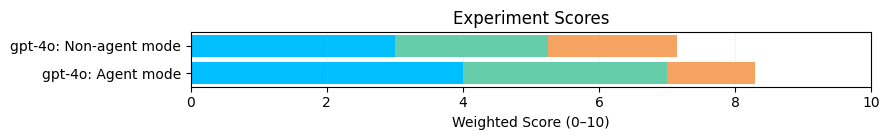

In [53]:
results = [
    [
    ExperimentResults(
        title="Agent mode",
        completeness=tc1_agent_results["completeness"].score,
        functional_parity=tc1_agent_results["function_parity"].score,
        residual_effort=tc1_agent_results["residual_effort"].score,
    ),
    ExperimentResults(
        title="Non-agent mode",
        completeness=tc1_non_agent_results["completeness"].score,
        functional_parity=tc1_non_agent_results["function_parity"].score,
        residual_effort=tc1_non_agent_results["residual_effort"].score,
    )
    ], 
]
plot_scores_grouped(
    results,
    ["gpt-4o"],
    weights=(0.5, 0.3, 0.2),
    scale=10.0,
)
